In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import project
from CMap2D import CMap2D, gridshow
import imageio as Image
import glob
from scipy.spatial.transform import Rotation as R
import os
from scipy.special import softmax

## Loading poses with localization (tf_echo map -> camera_link)

In [2]:
path_input = "../Results/Poses_Results/TF_with_localization/map_camera.txt"
path_output = "../Results/Poses_Results/TF_with_localization/map_camera_parsed.txt"

project.parse_pose_from_TF(path_input, path_output)
poses_TF_localization = pd.read_csv(path_output)

In [3]:
poses_TF_localization.head(5)

,Time,X,Y,Z,Roll,Pitch,Yaw
0,8603.967,0.89,-1.286,0.235,-0.0,-0.0,-2.156
1,8604.967,0.89,-1.286,0.235,-0.0,-0.0,-2.156
2,8605.968,0.89,-1.286,0.235,0.0,0.0,-2.157
3,8606.967,0.89,-1.287,0.235,-0.0,0.0,-2.156
4,8607.967,0.89,-1.288,0.235,-0.0,0.0,-2.156


### Load the occupancy grid and visualise the poses on the occupancy grid to see the trajectory of robot

Loading map definition from ../Results/Map/rtabmap.yaml
Map definition found. Loading map from ../Results/Map/rtabmap.pgm
(195, 2)
map origin spatial: [-5.53812 -5.47738]
origin ij: [[0 0]]


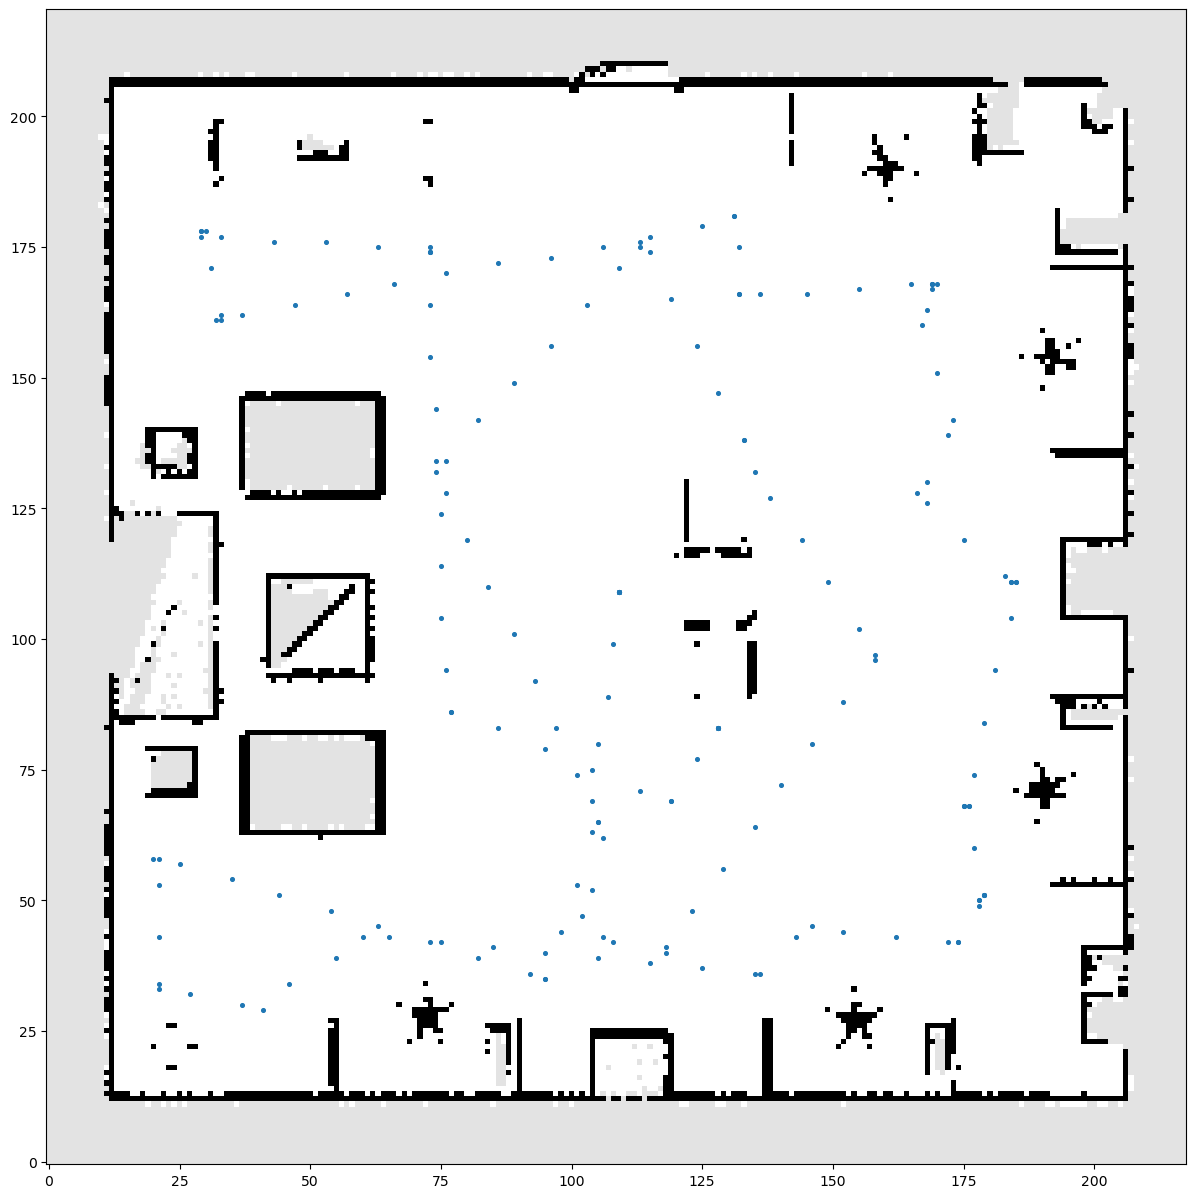

In [4]:
map = CMap2D("../Results/Map", "rtabmap")
occ_grid = map.occupancy()
origin = map.origin_xy()
x = poses_TF_localization['X']
y = poses_TF_localization['Y']
positions = np.zeros((x.shape[0],2))
print(positions.shape)
positions[:,0] = x
positions[:,1] = y
ij_positions = map.xy_to_ij(positions)
plt.figure(figsize=(15,15))
gridshow(occ_grid, cmap='Greys')
plt.scatter(ij_positions[:,0], ij_positions[:,1], s=7, )
print("map origin spatial:", origin)

origin_ij = map.xy_to_ij(origin.reshape(1,-1))
print("origin ij:", origin_ij)


### Load an rgb image and create the array of pixel coordinates

In [5]:
img = Image.v2.imread("../Results/RGBD/segment/8603.168000.jpg")

pixels = np.zeros((img.shape[1]*img.shape[0], 3), int)
count = 0
for i in range(img.shape[1]):
    for j in range(img.shape[0]):
        pixels[count, :] = [i,j,1]
        count +=1

### initialise the values for camera intrinsic matrix

In [6]:
K = np.array([554.3827128226441, 0.0, 320.5, 0.0, 554.3827128226441, 240.5, 0.0, 0.0, 1.0])
# camera intrinsic matrix
K = K.reshape(3,3)
K_inv = np.linalg.inv(K)

### Convert the pixel coordinates into camera rgb frame. 
(Currently the coordinates in this frame will be in canonical frame. we need to bring this into optical fram which is the camera frame)

In [7]:
camera_rgb_frame = (np.matmul(K_inv, pixels.T)).T # dimension [n,3]

### create matrix of depth values for all the images

In [8]:
depth_dir = '../Results/RGBD/depth/*.png'
depth_images = sorted(glob.glob(depth_dir))

z = np.zeros((len(depth_images), pixels.shape[0], 1))
for i in range(z.shape[0]):
    depth = Image.v2.imread(depth_images[i])
    for j in range(z.shape[1]):
        z[i,j,0] = depth[int(pixels[j,1]), int(pixels[j,0])] / 1000

### Create function to make homogenous transformation matrix

In [9]:
def homogenous1(roll, pitch, yaw, translation):
    rotation = R.from_euler('xyz', [roll, pitch, yaw])
    rotation = rotation.as_matrix()
    # translation = -np.matmul(rotation, translation)
    homogeneous_matrix = np.eye(4)
    homogeneous_matrix[:3, :3] = rotation
    homogeneous_matrix[:3, 3:] = translation

    return homogeneous_matrix

In [10]:
def homogenous2(roll, pitch, yaw, translation):
    rotation = R.from_euler('xyz', [roll, pitch, yaw])
    rotation = rotation.as_matrix()
    # translation = -np.matmul(rotation, translation)
    homogeneous_matrix = np.eye(4)
    homogeneous_matrix[:3, :3] = rotation
    homogeneous_matrix[:3, 3:] = translation

    return homogeneous_matrix

### Create function to plot the map with the transformed point coordinates

In [11]:
def plot_scatter(i, ij_positions, poses,map_frame):
    global depth_images
    r = 20
    plt.figure(figsize=(15,15))
    gridshow(occ_grid)

    dx = r * np.cos(poses['Yaw'][i])
    dy = r * np.sin(poses['Yaw'][i])
    x = ij_positions[i,0]
    y = ij_positions[i,1]

    name = os.path.basename(depth_images[i])
    plt.scatter(map_frame[:,1], map_frame[:, 0], s=25, c= 'b')
    plt.arrow(x, y, dx, dy, width=1, ec='r', fc='g')
    plt.scatter(x, y, s=25 , c='r')
    plt.savefig("../Results/plots/{}".format(name))
    plt.close()

### create matrix of transformation from canonical frame to optical frame

In [12]:
roll = -1.571
pitch = 0.00
yaw = -1.571
translation = np.array([[0.00, 0.00, 0.00]]).T
H = homogenous1(roll, pitch, yaw, translation)

### create matrix of tranformation matrix from camera frame to map frame

In [13]:
n_r_t = np.zeros((poses_TF_localization.shape[0], 4, 4))
for i in range(poses_TF_localization.shape[0]):
    tx = poses_TF_localization['X'][i]
    ty = poses_TF_localization['Y'][i]
    tz = poses_TF_localization['Z'][i]
    translation = np.array([[tx, ty, tz]]).T
    roll = poses_TF_localization['Roll'][i]
    pitch = poses_TF_localization['Pitch'][i]
    yaw = poses_TF_localization['Yaw'][i]
    n_r_t[i] = homogenous2(roll, pitch, yaw, translation)


### Final loop
We first multiply the pixel coordinates with the corresponding depth values associated with the image.

Then convert these coordinates which are currently in canonical frame into optical frame / camera frame.

Then convert these coordinates from the optical frame into the map frame. 

In [13]:
mask = False
for i in range(z.shape[0]):
    zi = z[i]
    
    #multiply depth
    camera_rgb_frame_z = (camera_rgb_frame * zi)
    
    #convert camera_rgb_frame into homogenous dimension
    ones = np.ones((z.shape[1],1))
    camera_rgb_frame_homo = np.column_stack((camera_rgb_frame_z,ones))

    #transform from canonical frame to optical frame ie camera frame
    camera_frame = H @ camera_rgb_frame_homo.T

    #transform from camera frame to map frame
    map_frame = (n_r_t[i] @ camera_frame).T

    if(mask):
        map_height_mask = map_frame[:,2] > np.mean(map_frame[:,2])
        map_frame_masked = map_frame[map_height_mask]
        map_frame_xy = map_frame_masked[:,[0,1]]

    #convert the coordinates from spatial coordinates (x,y) to ij coordinates to plot in occupancy grid
    else:
        map_frame_xy = map_frame[:,[0,1]]
    map_frame_xy = map_frame_xy.copy(order='C')
    map_frame_floatij = map.xy_to_floatij(map_frame_xy)
    # plot_scatter(i, ij_positions, poses_TF_localization, map_frame_floatij)
    

NameError: name 'z' is not defined

### Create visualisation from plots

In [ ]:
images_dir  = "../Results/plots/*.png"
images = sorted(glob.glob(images_dir))
image = []
for idx,i in enumerate(images):
    img = Image.v2.imread(i)
    image.append(img)

Image.mimsave('../images/camera_motion.gif', image, fps= 10)

### Camera motion visualisation

In [ ]:
from IPython.display import Image as im
im(url='../images/camera_motion.gif')  


### Experiments (to be removed)

In [14]:
labels_dir = "../../gradients/*.npy"
labels = sorted(glob.glob(labels_dir))

### assigning labels by adding up all the probabilities that points to the same cell or by multiplying the new probabilities for each label with its previous probability in the same cell

In [20]:
occ_grid_colorized = np.ones((occ_grid.shape[0], occ_grid.shape[1], 3), np.uint8) * 255
mask_height = False
occ_labels = {}
for i in range(z.shape[0]):
    zi = z[i]
    
    #multiply depth
    camera_rgb_frame_z = (camera_rgb_frame * zi)
    
    #convert camera_rgb_frame into homogenous dimension
    ones = np.ones((z.shape[1],1))
    camera_rgb_frame_homo = np.column_stack((camera_rgb_frame_z,ones))

    #transform from canonical frame to optical frame ie camera frame
    camera_frame = H @ camera_rgb_frame_homo.T

    #transform from camera frame to map frame
    map_frame = (n_r_t[i] @ camera_frame).T
    # print((np.min(map_frame[:,2]) + np.max(map_frame[:,2]) / 2))
    if(mask_height):
        map_height_mask = (map_frame[:,2] <= 0.145) & (map_frame[:,2] >= 0.125)
        map_frame_masked = map_frame[map_height_mask]
        map_frame_xy = map_frame_masked[:,[0,1]]

        # print(np.unique(map_frame_xy))
        # print(map_frame_xy.shape)
    #convert the coordinates from spatial coordinates (x,y) to ij coordinates to plot in occupancy grid
    else:
        map_frame_xy = map_frame[:,[0,1]]
    map_frame_xy = map_frame_xy.copy(order='C')
    map_frame_ij = map.xy_to_ij(map_frame_xy)
    mask = occ_grid[map_frame_ij[:,0], map_frame_ij[:,1]] == 1
    
    label = np.load(labels[i])
    for j in range(map_frame_ij.shape[0]):

        if(mask[j]):
            key = f"key_{map_frame_ij[j,0]}_{map_frame_ij[j,1]}"
        
            if (key in occ_labels):
                # multiplying probabilities
                # occ_labels[key]= [old_label * new_label for old_label, new_label in zip(occ_labels[key] , label[j])]
                # adding probabilities
                occ_labels[key]= [old_label + new_label for old_label, new_label in zip(occ_labels[key] , label[j])]
                prob_sum = np.sum(occ_labels[key])
                # print(prob_sum)
                occ_labels[key] = [probability / prob_sum for probability in occ_labels[key]]

                
            else:
                occ_labels[key] = label[j]
    
    print(i)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194


### Creating set of colors for the 37 labels

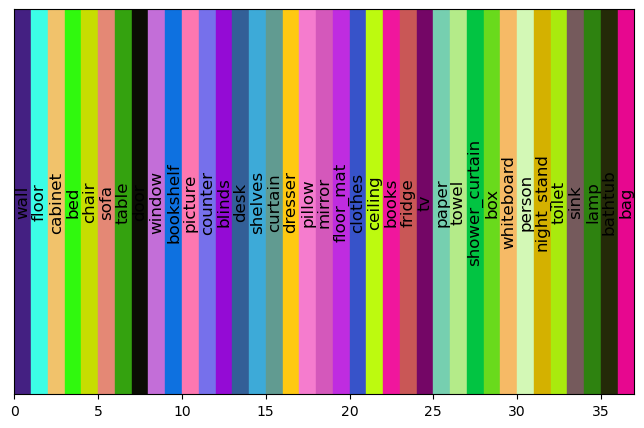

In [34]:
import random
random.seed(1)
def get_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)
        colors.append((r, g, b))
    return colors

def plot_colors(colors, label_names):
    num_colors = len(colors)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.set_xlim(0, num_colors)
    ax.set_ylim(0, 1)
    ax.set_yticks([])

    for i, color in enumerate(colors):
        # label = str(i)
        normalized_color = (color[0] / 255, color[1] / 255, color[2] / 255)  # Normalize to range [0, 1]
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=normalized_color))
        ax.text(i + 0.5, 0.5, label_names[i], color='black', ha='center', va='center', fontsize=12, rotation=90)

    # plt.savefig("color_labels.png")
    plt.show()

num_labels = 37
label_names = ['wall',
  'floor',
  'cabinet',
  'bed',
  'chair',
  'sofa',
  'table',
  'door',
  'window',
  'bookshelf',
  'picture',
  'counter',
  'blinds',
  'desk',
  'shelves',
  'curtain',
  'dresser',
  'pillow',
  'mirror',
  'floor_mat',
  'clothes',
  'ceiling',
  'books',
  'fridge',
  'tv',
  'paper',
  'towel',
  'shower_curtain',
  'box',
  'whiteboard',
  'person',
  'night_stand',
  'toilet',
  'sink',
  'lamp',
  'bathtub',
  'bag']
unique_colors = get_random_colors(num_labels)

### assigning label to occupancy grid based on the highest probability

In [26]:
for i in range(occ_grid_colorized.shape[0]):
    for j in range(occ_grid_colorized.shape[1]):
        key = f'key_{i}_{j}'
        if(key in occ_labels):
            values = occ_labels[key]
            values = softmax(values)
            label_id = np.argmax(values)
            occ_grid_colorized[i,j] = unique_colors[label_id]

### plotting the colorized occupancy grid

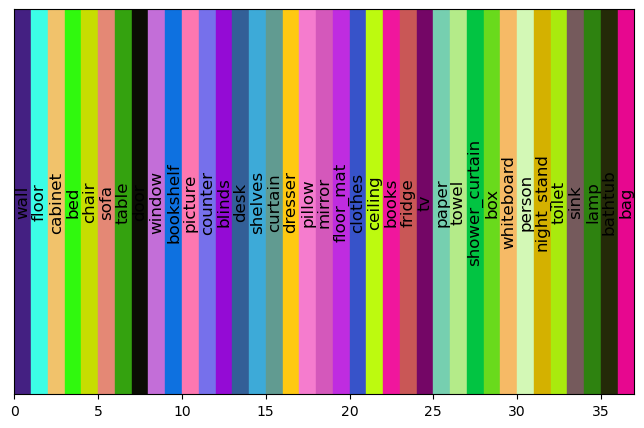

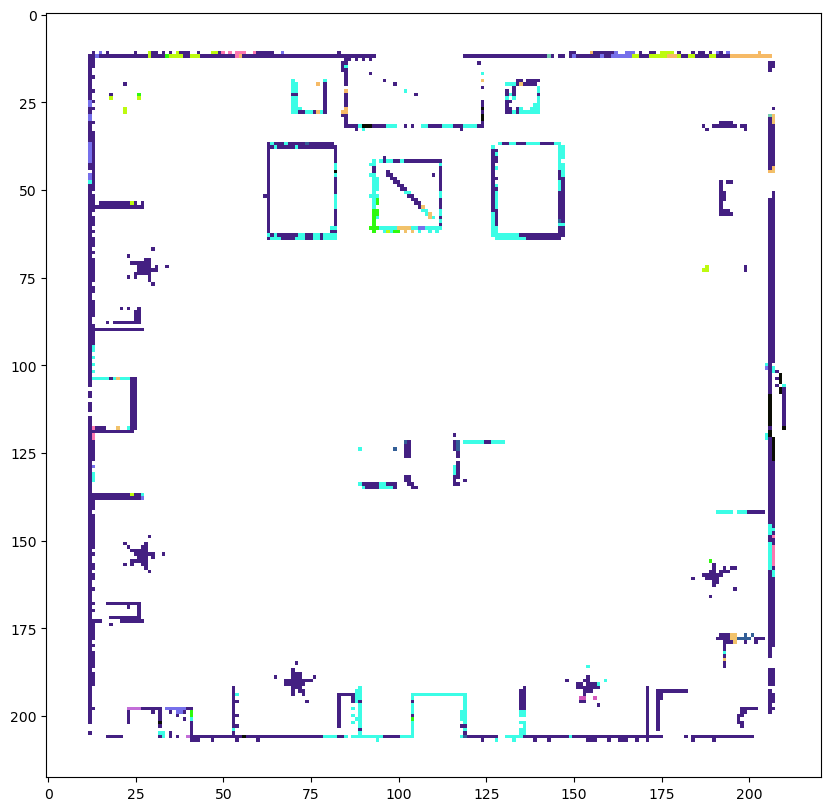

In [37]:
plot_colors(unique_colors, label_names)
plt.figure(figsize=(10,10))
plt.imshow(occ_grid_colorized)
plt.savefig("../Results/seg_map/seg_map_bayesian_multiply_probs.png")

### Assign labels to cells by most occuring label

In [38]:
occ_grid_colorized = np.ones((occ_grid.shape[0], occ_grid.shape[1], 3), np.uint8) * 255
mask_height = False
occ_labels = {}
for i in range(z.shape[0]):
    zi = z[i]
    
    #multiply depth
    camera_rgb_frame_z = (camera_rgb_frame * zi)
    
    #convert camera_rgb_frame into homogenous dimension
    ones = np.ones((z.shape[1],1))
    camera_rgb_frame_homo = np.column_stack((camera_rgb_frame_z,ones))

    #transform from canonical frame to optical frame ie camera frame
    camera_frame = H @ camera_rgb_frame_homo.T

    #transform from camera frame to map frame
    map_frame = (n_r_t[i] @ camera_frame).T
    # print((np.min(map_frame[:,2]) + np.max(map_frame[:,2]) / 2))
    if(mask_height):
        map_height_mask = (map_frame[:,2] <= 0.145) & (map_frame[:,2] >= 0.125)
        map_frame_masked = map_frame[map_height_mask]
        map_frame_xy = map_frame_masked[:,[0,1]]

        # print(np.unique(map_frame_xy))
        # print(map_frame_xy.shape)
    #convert the coordinates from spatial coordinates (x,y) to ij coordinates to plot in occupancy grid
    else:
        map_frame_xy = map_frame[:,[0,1]]
    map_frame_xy = map_frame_xy.copy(order='C')
    map_frame_ij = map.xy_to_ij(map_frame_xy)
    mask = occ_grid[map_frame_ij[:,0], map_frame_ij[:,1]] == 1
    
    # for j in range(occ_grid_colorized[map_frame_ij[:, 0], map_frame_ij[:, 1], :].shape[0]):
    #     if(mask[j].all()):
    #         # print(map_frame_ij[j, 0], map_frame_ij[j, 1])
    #         occ_grid_colorized[map_frame_ij[j, 0], map_frame_ij[j, 1], :] = labels[i,j,:]
    label = np.load(labels[i])
    # print(label.shape)
    for j in range(map_frame_ij.shape[0]):

        if(mask[j]):
            key = f"key_{map_frame_ij[j,0]}_{map_frame_ij[j,1]}"

            if (key in occ_labels):
                occ_labels[key]= np.vstack((occ_labels[key], np.argmax(label[j])))
            else:
                # print(np.argmax(label[j]))
                occ_labels[key] = np.argmax(label[j])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194


In [39]:
for i in range(occ_grid_colorized.shape[0]):
    for j in range(occ_grid_colorized.shape[1]):
        key = f'key_{i}_{j}'
        if(key in occ_labels):
            values = occ_labels[key]
            unique_labels, count = np.unique(values, return_counts=True)
            unique_idx = np.argmax(count)
            unique_label = unique_labels[unique_idx]
            # print(unique_label)
            occ_grid_colorized[i, j, :] = unique_colors[unique_label]

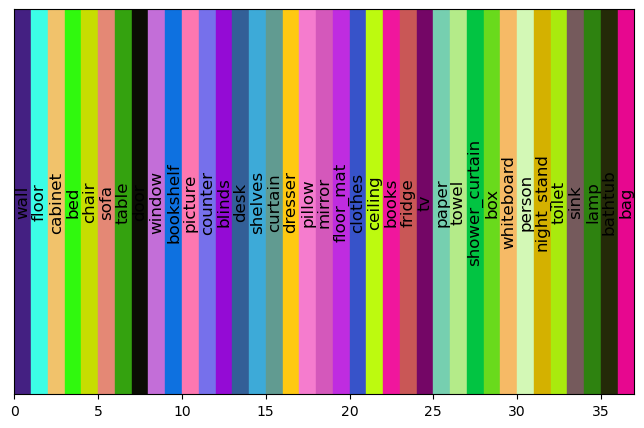

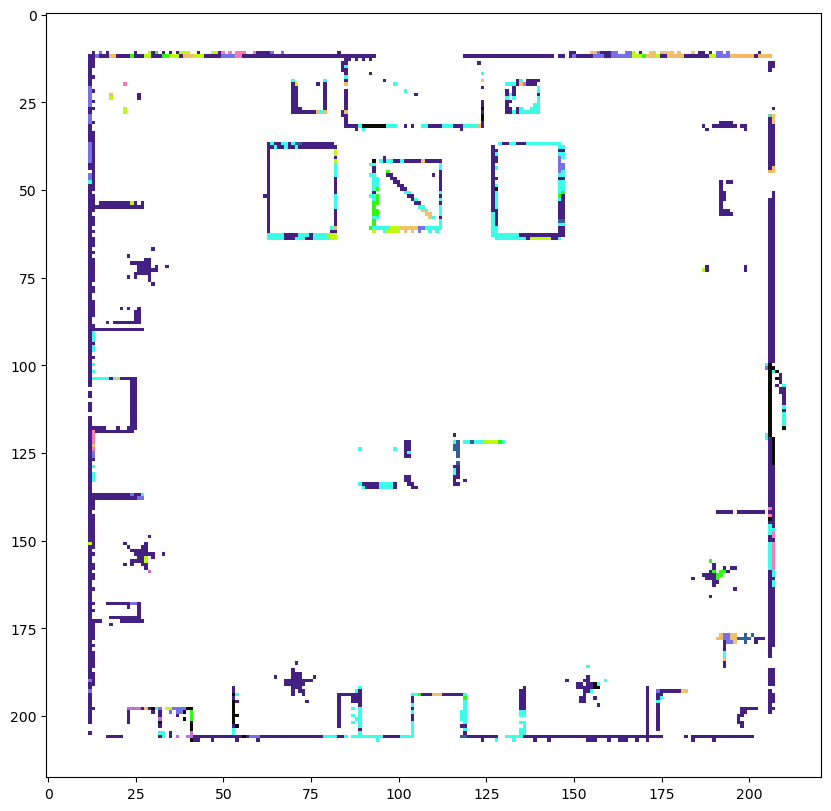

In [40]:
plot_colors(unique_colors, label_names)
plt.figure(figsize=(10,10))
plt.imshow(occ_grid_colorized)
plt.savefig("../Results/seg_map/seg_map_max_count.png")